Taken from: http://minds.jacobs-university.de/sites/default/files/uploads/mantas/code/minimalESN.py.txt
A minimalistic Echo State Networks demo with Mackey-Glass (delay 17) data 
in "plain" scientific Python.
by Mantas Lukosevicius  2012
http://minds.jacobs-university.de/mantas


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.linalg

In [3]:
# load the data
trainLen = 2000
testLen = 2000
initLen = 100

data = loadtxt('https://github.com/janchorowski/nn_assignments/raw/nn18/lectures/09-MackeyGlass_t17.txt')


Text(0.5, 1.0, 'A sample of data')

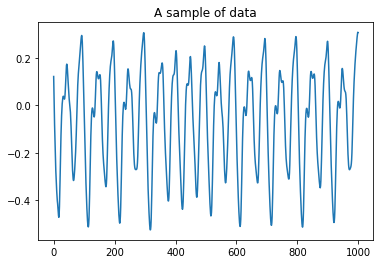

In [4]:
plot(data[0:1000])
title('A sample of data')

In [5]:
# generate the ESN reservoir
inSize = outSize = 1
resSize = 1000
a = 0.3 # leaking rate

random.seed(42)
Win = (random.rand(resSize, 1 + inSize) - 0.5) * 1.0
W = random.rand(resSize, resSize) - 0.5 

print('Computing spectral radius...',)
rhoW = max(abs(linalg.eig(W)[0]))
print('done.')
W *= 1.25 / rhoW

Computing spectral radius...
done.


In [6]:
# allocated memory for the design (collected states) matrix
H = zeros((1 + inSize + resSize, trainLen - initLen))
# set the corresponding target matrix directly
Yt = data[None, initLen + 1:trainLen + 1] 

# run the reservoir with the data and collect X
h = zeros((resSize, 1))
for t in range(trainLen):
    x = data[t]
    h = (1-a)*h + a*tanh( dot( Win, vstack((1,x)) ) + dot( W, h ) )
    if t >= initLen:
        H[:, t - initLen] = vstack((1, x, h))[:, 0]

In [7]:
# train the output
reg = 1e-8  # regularization coefficient
H_T = H.T
Wout = dot( dot(Yt,H_T), linalg.inv( dot(H, H_T) + 
    reg*eye(1+inSize+resSize) ) )

In [8]:
# run the trained ESN in a generative mode. no need to initialize here, 
# because h is initialized with training data and we continue from there.
Y = zeros((outSize,testLen))
x = data[trainLen]
for t in range(testLen):
    h = (1-a)*h + a*tanh( dot( Win, vstack((1,x)) ) + dot( W, h ) )
    y = dot( Wout, vstack((1,x,h)) )
    Y[:,t] = y
    # generative mode:
    x = y
    ## this would be a predictive mode:
    #x = data[trainLen+t+1] 


In [9]:
# compute MSE for the first errorLen time steps
errorLen = 500
mse = sum( square( data[trainLen+1:trainLen+errorLen+1] - Y[0,0:errorLen] ) ) / errorLen
print('MSE = ' + str(mse))


MSE = 2.1385226949802173e-06


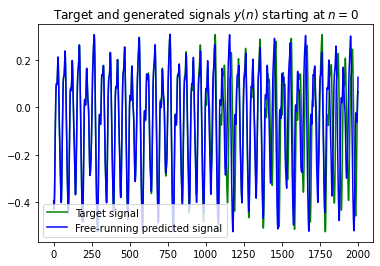

In [10]:
plot( data[trainLen+1:trainLen+testLen+1], 'g' )
plot( Y.T, 'b' )
title('Target and generated signals $y(n)$ starting at $n=0$')
legend(['Target signal', 'Free-running predicted signal'])


Text(0.5, 1.0, 'Some reservoir activations $\\mathbf{x}(n)$')

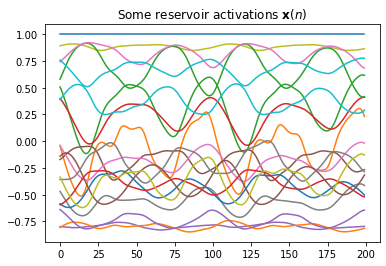

In [11]:
plot( H[0:20,0:200].T )
title('Some reservoir activations $\mathbf{x}(n)$')


Text(0.5, 1.0, 'Output weights $\\mathbf{W}^{out}$')

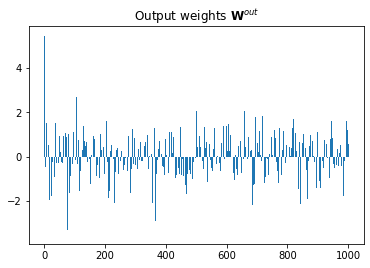

In [12]:
bar(range(1+inSize+resSize), Wout.ravel())
title('Output weights $\mathbf{W}^{out}$')